# Sales Forecasting with SARIMA

This notebook focuses on building a SARIMA model to forecast future sales.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.style.use('ggplot')

In [2]:
# Load Aggregated Data
data_path = "../data/monthly_sales.csv"
if not os.path.exists(data_path):
    data_path = "../../data/monthly_sales.csv"

df = pd.read_csv(data_path)
df['order_date'] = pd.to_datetime(df['order_date'])
df.set_index('order_date', inplace=True)

print(df.head())

                sales
order_date           
2014-01-31  14236.895
2014-02-28   4519.892
2014-03-31  55691.009
2014-04-30  28295.345
2014-05-31  23648.287


## 1. Stationarity Check (ADF Test)

In [4]:
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Data is Stationary")
    else:
        print("Data is Non-Stationary")

adf_test(df['sales'])

ADF Statistic: -4.493767844002667
p-value: 0.00020180198458237607
Data is Stationary


## 2. Train/Test Split

In [5]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 38, Test size: 10


## 3. SARIMA Model Training
Using order=(1,1,1) and seasonal_order=(1,1,1,12) as a starting point.

In [6]:
model = SARIMAX(train['sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()
print(results.summary())

c:\Users\rolir\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\rolir\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\rolir\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                   38
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -271.327
Date:                            Sat, 07 Feb 2026   AIC                            552.653
Time:                                    15:10:30   BIC                            558.748
Sample:                                01-31-2014   HQIC                           554.344
                                     - 02-28-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6183      0.252      2.451      0.014       0.124       1.113
ma.L1         -0.8921      0.199   

## 4. Evaluation

c:\Users\rolir\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


MAE: 11712.762869883183
RMSE: 13995.699883660234


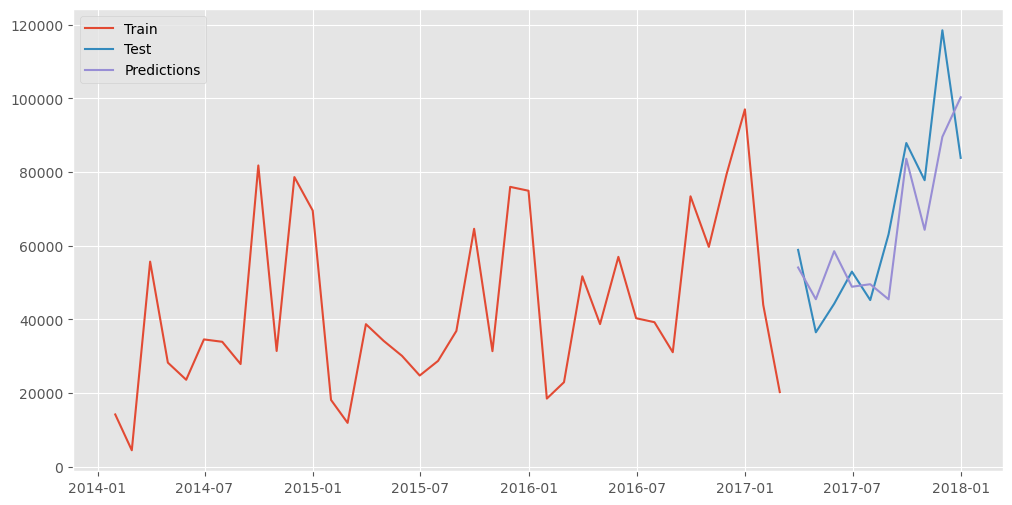

In [7]:
predictions = results.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
predictions.index = test.index

mae = mean_absolute_error(test['sales'], predictions)
rmse = np.sqrt(mean_squared_error(test['sales'], predictions))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

plt.figure(figsize=(12, 6))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()

## 5. Future Forecast


In [8]:
# Retrain on full data
final_model = SARIMAX(df['sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
final_results = final_model.fit()

# Forecast next 12 months
forecast = final_results.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Prepare DataFrame
# Combine Historical and Forecast
historical_df = df.copy()
historical_df['Type'] = 'Historical'

forecast_df = pd.DataFrame({
    'sales': forecast_mean,
    'Type': 'Forecast'
})
forecast_df.index.name = 'order_date'

final_df = pd.concat([historical_df, forecast_df.reset_index().set_index('order_date')])
final_df.reset_index(inplace=True)

# Save functionality commented out as Power BI is not used
# export_path = "../data/forecast_results.csv"
# final_df.to_csv(export_path, index=False)
# print(f"Exported forecast results to {export_path}")

c:\Users\rolir\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\rolir\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\rolir\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
